In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn import metrics
import calendar
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
dg = pd.read_csv("C:\\Users\\shami\\Downloads\\cleaned_merged_data.csv")



- 3 models will be trained/tested: Linear Regression, Decision Trees and Random Forest
- Evaluation stats: MAE, MSE, RMSE
- Linear Regression
    - Applied Feature Scaling since some features have varying magnitudes i.e uvindex and temperature
    - No tuning required
- Decision Tree
    - Use pipeline approach to get optimal parameters for max depth and min_samples_leaf using GridCV
    - Best estimator picked
- Random Forest
    - Plotted RMSE as function of number of trees and picked where RMSE is minimized to use as best estimator
- A function to input model name, location, year to plot actual and predicted PV Potentials for visualization
- BEST MODEL FOUND: RANDOM FOREST
    



In [2]:
dg.head(5)

,Unnamed: 0,Province,location,month,PVpot tilt=90,PVpot tilt=lat,PVpot tilt=lat+15,PVpot tilt=lat-15,AvgPVPotential,PVPotential,latitude,longitude,temperature,uv_index,wind_speed,cloud_cover,precip_intensity,year
0,0,Ontario,Casselman,January,82.0,78.0,84.0,68.0,78.00,84.0,45.313529,-75.086746,-3.783835,0.602151,10.693978,0.772294,0.018808,2017
1,1,Ontario,Casselman,January,82.0,78.0,84.0,68.0,78.00,84.0,45.313529,-75.086746,-8.174803,0.616487,11.618423,0.805591,0.044539,2018
2,2,Ontario,Casselman,February,94.0,97.0,101.0,88.0,95.00,101.0,45.313529,-75.086746,-3.085040,1.277778,11.819484,0.736667,0.032070,2017
3,3,Ontario,Casselman,February,94.0,97.0,101.0,88.0,95.00,101.0,45.313529,-75.086746,-2.404643,1.246032,11.607937,0.734405,0.055358,2018
4,4,Ontario,Casselman,March,103.0,125.0,123.0,120.0,117.75,123.0,45.313529,-75.086746,-3.388925,2.415771,14.013226,0.646953,0.022958,2017


In [3]:
#refine data columns
dg['month'] = dg['month'].str[:3]
dg['date'] = dg['month'] + ' ' + dg['year'].astype('str')
dg.head(5)

,Unnamed: 0,Province,location,month,PVpot tilt=90,PVpot tilt=lat,PVpot tilt=lat+15,PVpot tilt=lat-15,AvgPVPotential,PVPotential,latitude,longitude,temperature,uv_index,wind_speed,cloud_cover,precip_intensity,year,date
0,0,Ontario,Casselman,Jan,82.0,78.0,84.0,68.0,78.00,84.0,45.313529,-75.086746,-3.783835,0.602151,10.693978,0.772294,0.018808,2017,Jan 2017
1,1,Ontario,Casselman,Jan,82.0,78.0,84.0,68.0,78.00,84.0,45.313529,-75.086746,-8.174803,0.616487,11.618423,0.805591,0.044539,2018,Jan 2018
2,2,Ontario,Casselman,Feb,94.0,97.0,101.0,88.0,95.00,101.0,45.313529,-75.086746,-3.085040,1.277778,11.819484,0.736667,0.032070,2017,Feb 2017
3,3,Ontario,Casselman,Feb,94.0,97.0,101.0,88.0,95.00,101.0,45.313529,-75.086746,-2.404643,1.246032,11.607937,0.734405,0.055358,2018,Feb 2018
4,4,Ontario,Casselman,Mar,103.0,125.0,123.0,120.0,117.75,123.0,45.313529,-75.086746,-3.388925,2.415771,14.013226,0.646953,0.022958,2017,Mar 2017


In [4]:
#Zone divisions
Zone1 = ['Camden East', 'Casselman', 'Karalash Corners', 'Ompah', 'Providence Bay', 'Waupoos']
Zone2 = ['Cobalt', 'Muskrat Dam', 'Nipigon', 'Smooth Rock Falls', 'Terrace Bay', 'Thornloe']
Zone3 = ['Kitchener', 'Lambton Shores', 'Milverton', 'Oakville', 'Tara', 'Zephyr']

def ZoneAllocation(row):
    if row['location'] in Zone1:
        return 'Zone 1'
    elif row['location'] in Zone2:
        return 'Zone 2'
    else:
        return 'Zone 3'


dg['Zone'] = dg.apply (lambda row: ZoneAllocation(row), axis=1)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:2257: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


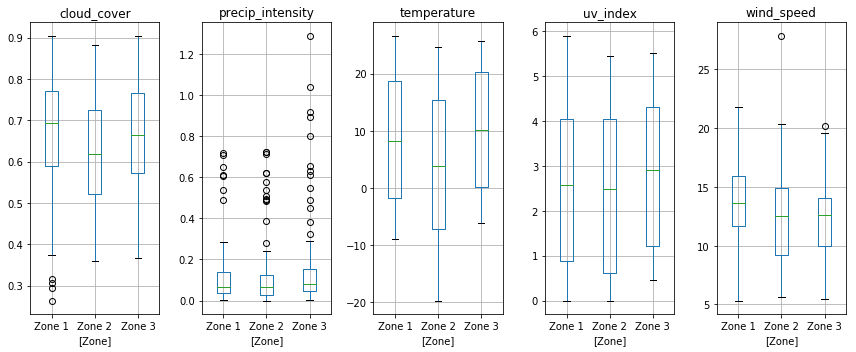

In [5]:
#dg.boxplot(column = 'temperature', by = 'Zone',grid=False,figsize=(8,10))

boxplots = ['Zone','temperature','uv_index', 'wind_speed', 'cloud_cover','precip_intensity']

temp = dg[boxplots]

fig, axes = plt.subplots(ncols=5, figsize=(12, 5), sharey=False)
temp.query("Zone in ['Zone 1', 'Zone 2', 'Zone 3']").boxplot(by='Zone', return_type='axes', ax=axes)
plt.suptitle("")
plt.tight_layout()

In [6]:
#select features + output
cols = ['temperature','uv_index', 'wind_speed', 'cloud_cover','precip_intensity','PVPotential']
df  = dg[cols]
df.head(5)

,temperature,uv_index,wind_speed,cloud_cover,precip_intensity,PVPotential
0,-3.783835,0.602151,10.693978,0.772294,0.018808,84.0
1,-8.174803,0.616487,11.618423,0.805591,0.044539,84.0
2,-3.085040,1.277778,11.819484,0.736667,0.032070,101.0
3,-2.404643,1.246032,11.607937,0.734405,0.055358,101.0
4,-3.388925,2.415771,14.013226,0.646953,0.022958,123.0


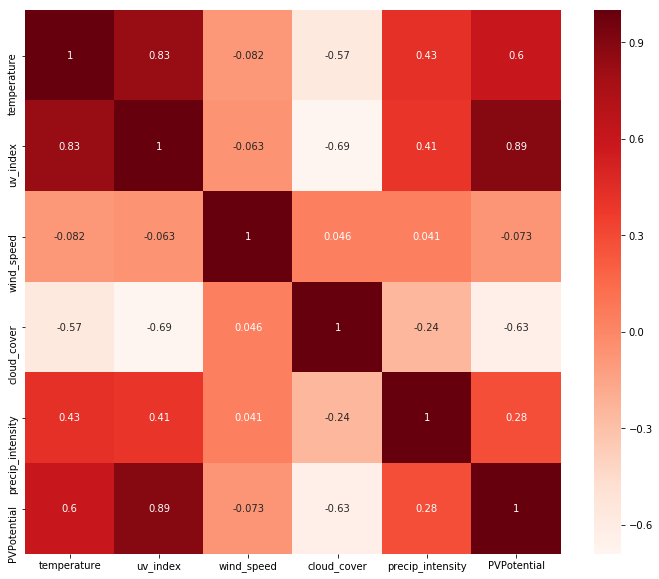

In [7]:
#examine correlations between vars
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

Let's define criteria for exclusion of highly correlated predictor variables to be >= 0.9 or <= -0.9
Based on matrix above, we can include all features

In [8]:
#define features and output

X = df.iloc[:, 0:5].values
y = df.iloc[:, 5].values

#split training/test set as 80% and 20% respectively
#can change it to 70/30 ratio but due to relatively low number of training points about 430, kept as 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## LINEAR REGRESSION

In [9]:
#Apply feature scaling to bring all features to same magnitude, recommended when differeing magnitude ranges for predictors
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test) 

#instantiate linearregression
linreg = LinearRegression()
linreg.fit(X_train_scaled,y_train)
yactual = linreg.predict(X_test_scaled)

#print coeffs
print(linreg.coef_)



[-11.84229552  35.44474469  -0.69101523  -0.8094455   -1.306551  ]


In [10]:
#print linear regression evaluation statistics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, yactual))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, yactual))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, yactual)))

Mean Absolute Error: 8.951348942585948
Mean Squared Error: 119.94709778548827
Root Mean Squared Error: 10.952036239233701


## DECISION TREE

In [11]:
#use pipeline approach to finding optimal decision tree params

pipe_tree = make_pipeline(tree.DecisionTreeRegressor(random_state = 1))

In [12]:
#array of params to test

depths = np.arange(1, 40)
num_leafs = [1, 2, 3, 4]

In [13]:
param_grid = [{'decisiontreeregressor__max_depth':depths,
              'decisiontreeregressor__min_samples_leaf':num_leafs}]

In [14]:
#cv param is number of times data is split into train/test for validation set for each combinaton of parameters in param_grid
gs = GridSearchCV(estimator=pipe_tree, param_grid=param_grid, cv=3)

In [15]:
gs = gs.fit(X_train, y_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [16]:
#print mean cross-validation score of best estimator
print(-gs.best_score_)

-0.9015371815207823


In [17]:
print(gs.best_params_)

{'decisiontreeregressor__max_depth': 4, 'decisiontreeregressor__min_samples_leaf': 2}


In [18]:
#Best DT estimator
dt_regressor = gs.best_estimator_
dt_regressor

Pipeline(memory=None,
     steps=[('decisiontreeregressor', DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best'))])

In [19]:
#predict DT results on test set using best params
dt_regressor.fit(X_train, y_train)

y_predicted = dt_regressor.predict(X_test)

In [20]:
#print decision tree evaluation statistics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predicted))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))

Mean Absolute Error: 6.142074626800948
Mean Squared Error: 66.33793095574985
Root Mean Squared Error: 8.144810062595067


## RANDOM FOREST

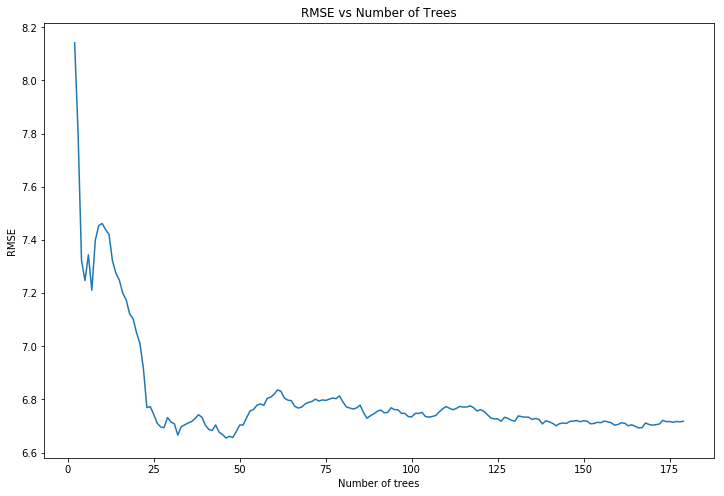

In [21]:
num_trees = list(range(2,180))
rmse = []

for i in num_trees:
    rf_regressor = RandomForestRegressor(n_estimators = i,random_state = 1)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)
    rmse.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

plt.figure(figsize=(12,8))
plt.xlabel('Number of trees'); plt.ylabel('RMSE'); plt.title('RMSE vs Number of Trees')
plt.plot(num_trees,rmse)

In [22]:
#find best rf model from above graph that minimizes rmse and predict
rf_regressor = RandomForestRegressor(n_estimators=num_trees[rmse.index(min(rmse))], random_state=1)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)


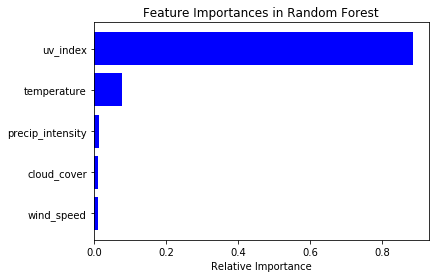

In [23]:
#examine features importance

feature_cols = ['temperature','uv_index', 'wind_speed', 'cloud_cover','precip_intensity']


importances = rf_regressor.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances in Random Forest')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [24]:
#print random forest evaluation statistics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 4.430990899898887
Mean Squared Error: 44.285592605618326
Root Mean Squared Error: 6.6547421141332235


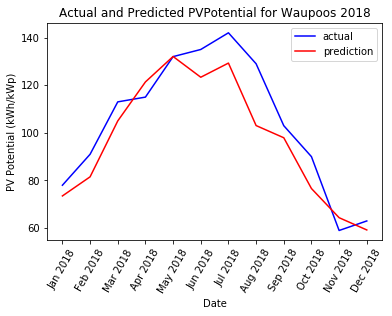

In [25]:
# predict and plot actual vs prediction values for any location and year available for trained models
def predictnplot_PVPotential(model, place, year):
    x = dg[(dg["location"] == place) & (dg["year"] == year)]['date']
    y = dg[(dg["location"] == place) & (dg["year"] == year)]['PVPotential']
    features = dg[(dg["location"] == place) & (dg["year"] == year)].iloc[:, 12:17].values
    
    
    if model == 'RF':
        y_predicted = rf_regressor.predict(features)
    elif model == 'DT':
        y_predicted = dt_regressor.predict(features)
    elif model == 'LR':
        features_scaled = scaler.transform(features) 
        y_predicted = linreg.predict(features_scaled)
    else:
        return 'invalid model - model name can be ''RF'' or ''DT'' or ''LR'' only'
    
    plt.figure(figsize=(6,4))
    plt.xticks(rotation = '60')
    plt.xlabel('Date'); plt.ylabel('PV Potential (kWh/kWp)'); plt.title('Actual and Predicted PVPotential for '+place+' '+str(year));
    plt.plot(x,y,'b-',label='actual')
    plt.plot(x,y_predicted,'-r',label='prediction')
    plt.legend()
    return plt.show()

#input any location, year and model to view the actual and predicted output graphically
predictnplot_PVPotential('LR', 'Waupoos', 2018)

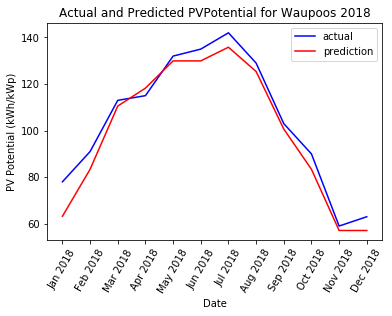

In [26]:
predictnplot_PVPotential('DT', 'Waupoos', 2018)

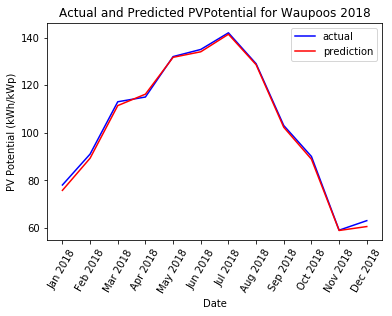

In [27]:
predictnplot_PVPotential('RF', 'Waupoos', 2018)